Hi Veronika, I've written notes where need to add images, Please feel free to add any data analysis charts and model codes as you want

## Imports

In [ ]:
%%capture
! pip install --upgrade medcat
! pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_md-0.2.4.tar.gz

In [ ]:
import pandas as pd
import csv
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from medcat.vocab import Vocab
from medcat.cdb import CDB
from medcat.cat import CAT

from medcat.meta_cat import MetaCAT
import pickle

from tqdm.notebook import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

from scipy.stats import mode
import spacy
from ast import literal_eval

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
import time
warnings.filterwarnings('ignore')

In [ ]:
%%capture
! pip install catboost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

In [ ]:
%%capture
! pip install optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

## Working with Medcat

### Data Loading

Loading Medcat

In [ ]:
! unzip "Medcat.zip"

Archive:  Medcat.zip
  inflating: cdb-medmen-v1.dat       
   creating: Status/
  inflating: Status/bbpe-merges.txt  
  inflating: Status/bbpe-vocab.json  
  inflating: Status/config.json      
  inflating: Status/model.dat        
  inflating: vocab.dat               


In [ ]:
#medcat model path
vocab_path = r"vocab.dat"
cdb_path = r"cdb-medmen-v1.dat"
status_path = r"Status"

vocab=None
cdb=None
cat=None


model_loaded = False

def loadmodel():
    global vocab, cdb, cat
    if vocab is None or cdb is None or cat is None:
        print("**load model")
        # Load the vocab model you downloaded
        vocab = Vocab.load(vocab_path)
        # Load the cdb model you downloaded
        cdb = CDB.load(cdb_path)
        # Create cat - each cdb comes with a config that was used
        #to train it. You can change that config in any way you want, before or after creating cat.
        cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab)
        # Assume we have a CDB and Vocab object from before
        mc_status = MetaCAT.load(status_path)
        cat = CAT(cdb=cdb, config=cdb.config, vocab=vocab, meta_cats=[mc_status])

def med_analysis(text):
    global cat
    if cat is None:
        # print("load model")
        loadmodel()
    doc = cat.get_entities(text)
    #print(doc)
    return doc


Read mimic-iii dataset

In [ ]:
input_file_name = r"NOTEEVENTS.csv"
icd_file_name=r"DIAGNOSES_ICD.csv"

notefile=pd.read_csv(input_file_name)
icdfile=pd.read_csv(icd_file_name)

In [ ]:
notefile.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


### Medcat Processing

In [ ]:
#show the number of records and patients
patient_id=notefile['SUBJECT_ID'].unique()
print("the number of records are:",notefile['SUBJECT_ID'].count())
print("The number of patients are:",len(patient_id))

the number of records are: 100
The number of patients are: 60


In [ ]:
notefile['SUBJECT_ID'].value_counts()

Data processed by Medcat:

In [ ]:
def med_extract(Subject_ID,HADM_ID):
    target_types = ['Sign or Symptom', 'Disease or Syndrome',
                    'Pathologic Function',
                    'Body Part, Organ, or Organ Component',
                    'CRANIOCEREBRAL INJ']

    target_status = 'Affirmed'
    symptoms_dict = []
    note_dict = notefile[(notefile['SUBJECT_ID']==Subject_ID) &
                        (notefile['HADM_ID']==HADM_ID)]['TEXT']
    note_num = len(note_dict)
    for note in note_dict:
        note_with_spaces = note.replace('\n',' ')
        med_data = med_analysis(note_with_spaces)
        if 'entities' in med_data and med_data['entities']:
            for i in med_data['entities'].keys():
                entity = med_data['entities'][i]
                if any(target in entity['types'] for target in target_types) :
                    #print(entity)
                    symptoms_dict.append(entity['pretty_name'])

    return list(set(symptoms_dict)),note_num

In [ ]:
def get_id():
    patient_id=notefile['SUBJECT_ID'].unique()
    dict={id: notefile[(notefile['SUBJECT_ID'] == id)
                    ]['HADM_ID'].unique() for id in patient_id }
    return dict

In [ ]:
def get_icd(Subject_ID,HADM_ID):
    return list(icdfile[(icdfile['SUBJECT_ID']==Subject_ID)
                & (icdfile['HADM_ID']==HADM_ID)]['ICD9_CODE'])

In [ ]:
#one example for med_extract function
med_extract(22532,167853)

**load model


e:\Environment\Python\Lib\site-packages\spacy\language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


(['Leg',
  'Coughing',
  'Hip structure',
  'Heart',
  'Left Ventricular Hypertrophy',
  'Congestive heart failure',
  'anatomical layer',
  'Bleeding, Intracranial',
  'Thickening of pleura',
  'Tuberculosis',
  'Ear structure',
  'Hypertensive disease',
  'Pulmonary Hypertension',
  'lobe',
  'Vasculitis',
  'Bone structure of sacrum',
  'Left ventricular structure',
  'Infectious disease of lung',
  'acute infection',
  'Structure of upper lobe of lung',
  'Structure of lobe of lung',
  'Pericardial sac structure',
  'Thoracic spine structure',
  'Hypoventilation',
  'Haemodynamic instability',
  'Right ventricular structure',
  'Urinary Bladder',
  'Parietal Lobe',
  'Eye',
  'Aortic Valve Insufficiency',
  'Osteoporosis',
  'Nose',
  'Ulcerative Colitis',
  'Aorta',
  'Bronchioles',
  'Stomach',
  'Chronic constipation',
  'Vertebral column',
  'Lymphadenopathy',
  'Tuberculosis, Spinal',
  'All extremities',
  'parenchyma',
  'Sore to touch',
  'Infection',
  'Hypertension, systo

In [ ]:
from concurrent.futures import ThreadPoolExecutor

subject_hadm_dict=get_id()
def process_subject(subject):
    hadm_id_list = subject_hadm_dict[subject]
    hadm_id_list = hadm_id_list[~np.isnan(hadm_id_list)]
    results = []
    for hadm_id in hadm_id_list:
        icd9 = get_icd(subject, hadm_id)
        symptoms, note_num = med_extract(subject, hadm_id)
        results.append([subject, hadm_id, icd9, symptoms, note_num])
    return results

def output():
    file_path=os.path.join("medcat_mimiciii.csv")

    subject_id=list(subject_hadm_dict.keys())



    with ThreadPoolExecutor(max_workers=5) as executor:
            future_to_subject = {executor.submit(process_subject, subject): subject for subject in subject_id}

            with open(file_path, 'w', newline='', encoding='utf-8') as file:
                writer = csv.writer(file)
                writer.writerow(['SUBJECT_ID', 'HADM_ID', 'ICD9-CODE', 'MED_SYMPTOMS', 'NUM_NOTES'])

                for future in tqdm(concurrent.futures.as_completed(future_to_subject), desc="Processing subjects"):
                    subject = future_to_subject[future]
                    try:
                        results = future.result()
                        for result in results:
                            writer.writerow(result)
                    except Exception as exc:
                        print(f"{subject} generated an exception: {exc}")


In [ ]:
output()

## Data Analysis

### Symptom Frequencies

In [ ]:
def string2list(dataset, col):
  icd9 = dataset[col].to_numpy()
  for i in range(len(icd9)):
      icd9[i] = icd9[i].replace("[",'')
      icd9[i] = icd9[i].replace("]",'')
      icd9[i] = icd9[i].replace("'",'')
      icd9[i] = icd9[i].split(', ')
 # icd9_unique = set([num for ppl in icd9 for num in ppl])
  return icd9

In [ ]:
df_exploded = pd.read_csv('mimiciii-top10.csv')

string2list(df_exploded, 'MED_SYMPTOMS')
string2list(df_exploded, 'ICD9-CODE')
df_exploded

,Unnamed: 0,SUBJECT_ID,HADM_ID,ICD9-CODE,MED_SYMPTOMS,NUM_NOTES
0,0,22532,167853.0,[42731],"[Cardiac chamber structure, Body of vertebra, ...",32
1,1,13702,107527.0,[51881],"[Cor pulmonale, Brain, Lung diseases, Angina P...",47
2,3,13702,196489.0,"[5849, 41401, 2724, 4019]","[Cardiac chamber structure, Anterior descendin...",26
3,4,26880,135453.0,"[4280, 42731]","[Benign Prostatic Hyperplasia, Sleep Apnea Syn...",39
4,5,53181,170490.0,[53081],"[Syndrome, capillaries lung, Symptoms, Left ve...",7
...,...,...,...,...,...,...
41531,54948,28633,181354.0,[4019],"[Heart, Airway structure, Stiffness, Fever, Kn...",13
41532,54949,29543,101157.0,[5849],"[Knee, Chest Pain, Leg, Corpus striatum struct...",12
41533,54950,30037,118816.0,"[25000, 4019]","[artery coronary stenosis, fungal pneumonia, P...",1
41534,55047,32711,133527.0,"[42731, 53081, 4019]","[Coronary Arteriosclerosis, Nausea, Pain, Gest...",2


In [ ]:
df_exploded1 = df_exploded.explode('ICD9-CODE')
df_exploded2 = df_exploded.explode('MED_SYMPTOMS')

In [ ]:
disease_counts=df_exploded1['ICD9-CODE'].value_counts()
disease_counts

4019     20562
4280     13062
42731    12805
41401    12383
5849      9066
25000     9003
2724      8630
51881     7410
5990      6522
53081     6292
Name: ICD9-CODE, dtype: int64

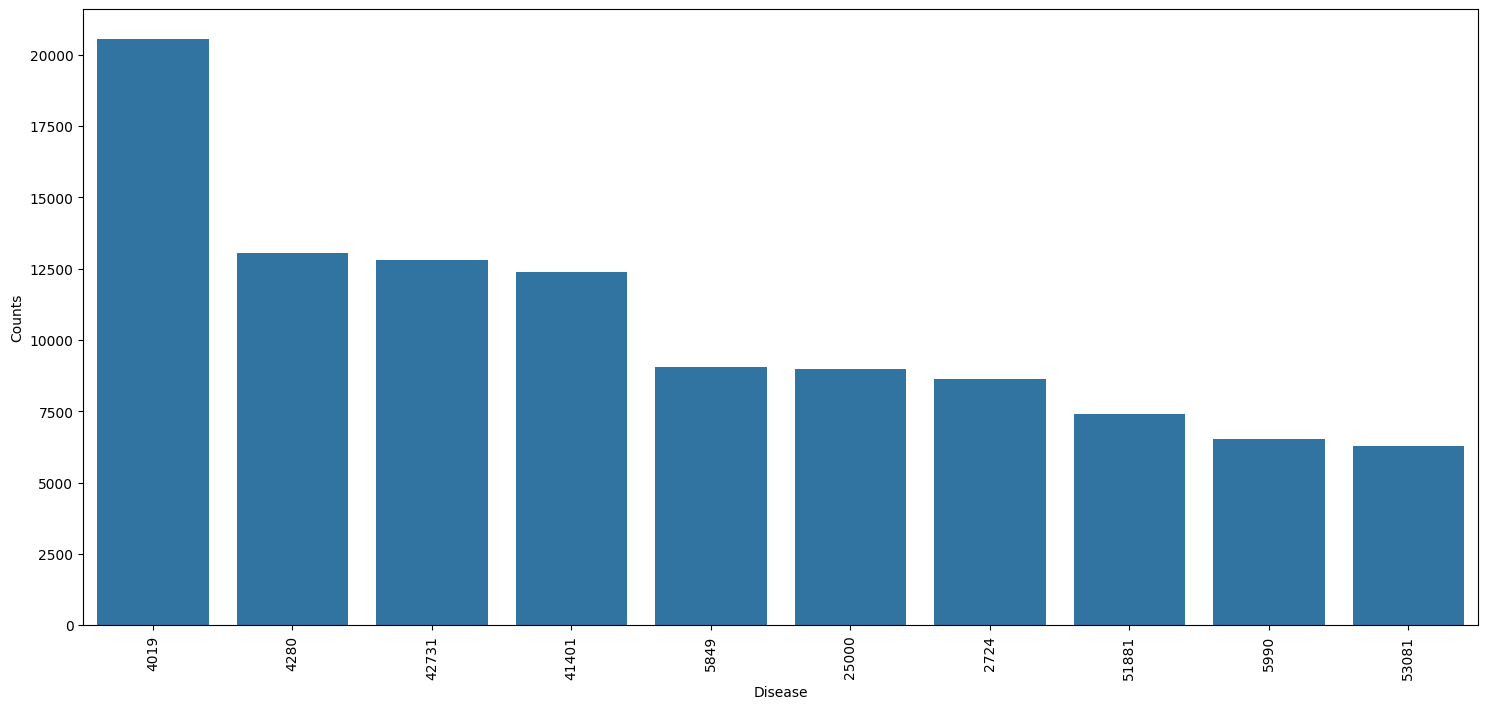

In [ ]:
temp_df = pd.DataFrame({"Disease": disease_counts.index, "Counts":disease_counts.values})
plt.figure(figsize=(18,8))
sns.barplot(x='Disease', y='Counts', data=temp_df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
symptoms_counts=df_exploded2['MED_SYMPTOMS'].value_counts()
symptoms_counts

Illness (finding)                  40126
Diabetes Mellitus                  39992
Lung                               39864
Hypertensive disease               37904
Pain                               36052
                                   ...  
Hypoplastic Left Heart Syndrome        1
Warts                                  1
hypogammaglobulinaemia                 1
infections                             1
disorders motility                     1
Name: MED_SYMPTOMS, Length: 2339, dtype: int64

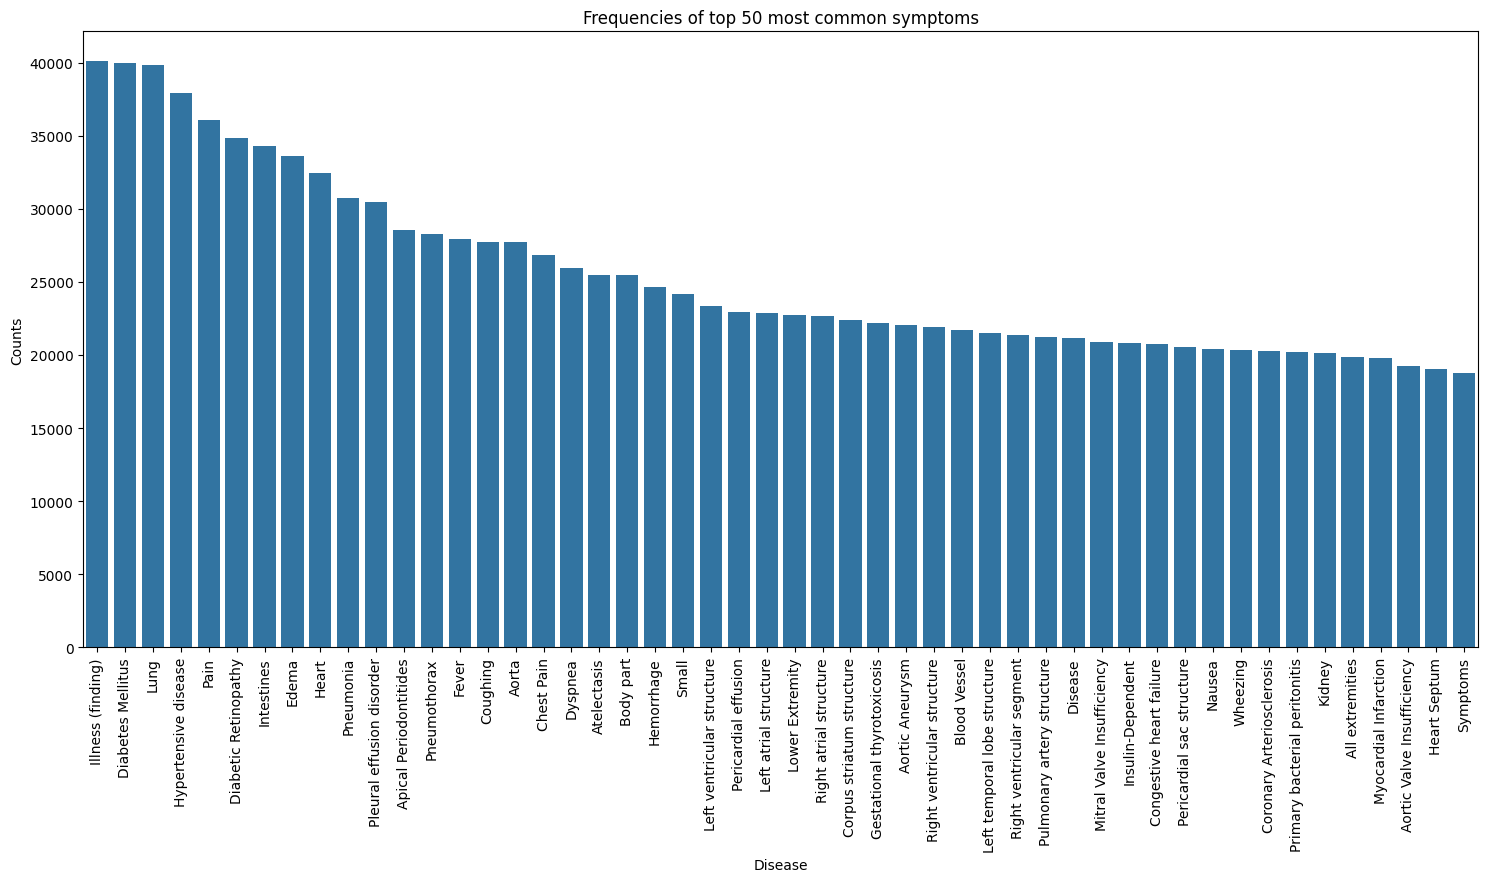

In [ ]:
temp_df = pd.DataFrame({"Disease": symptoms_counts.index,
                        "Counts":symptoms_counts.values})
temp_df = temp_df.sort_values(by='Counts', ascending=False)[:50]

plt.figure(figsize=(18,8))
plt.title("Frequencies of top 50 most common symptoms")
sns.barplot(x='Disease', y='Counts', data=temp_df)
plt.xticks(rotation=90)
plt.show()

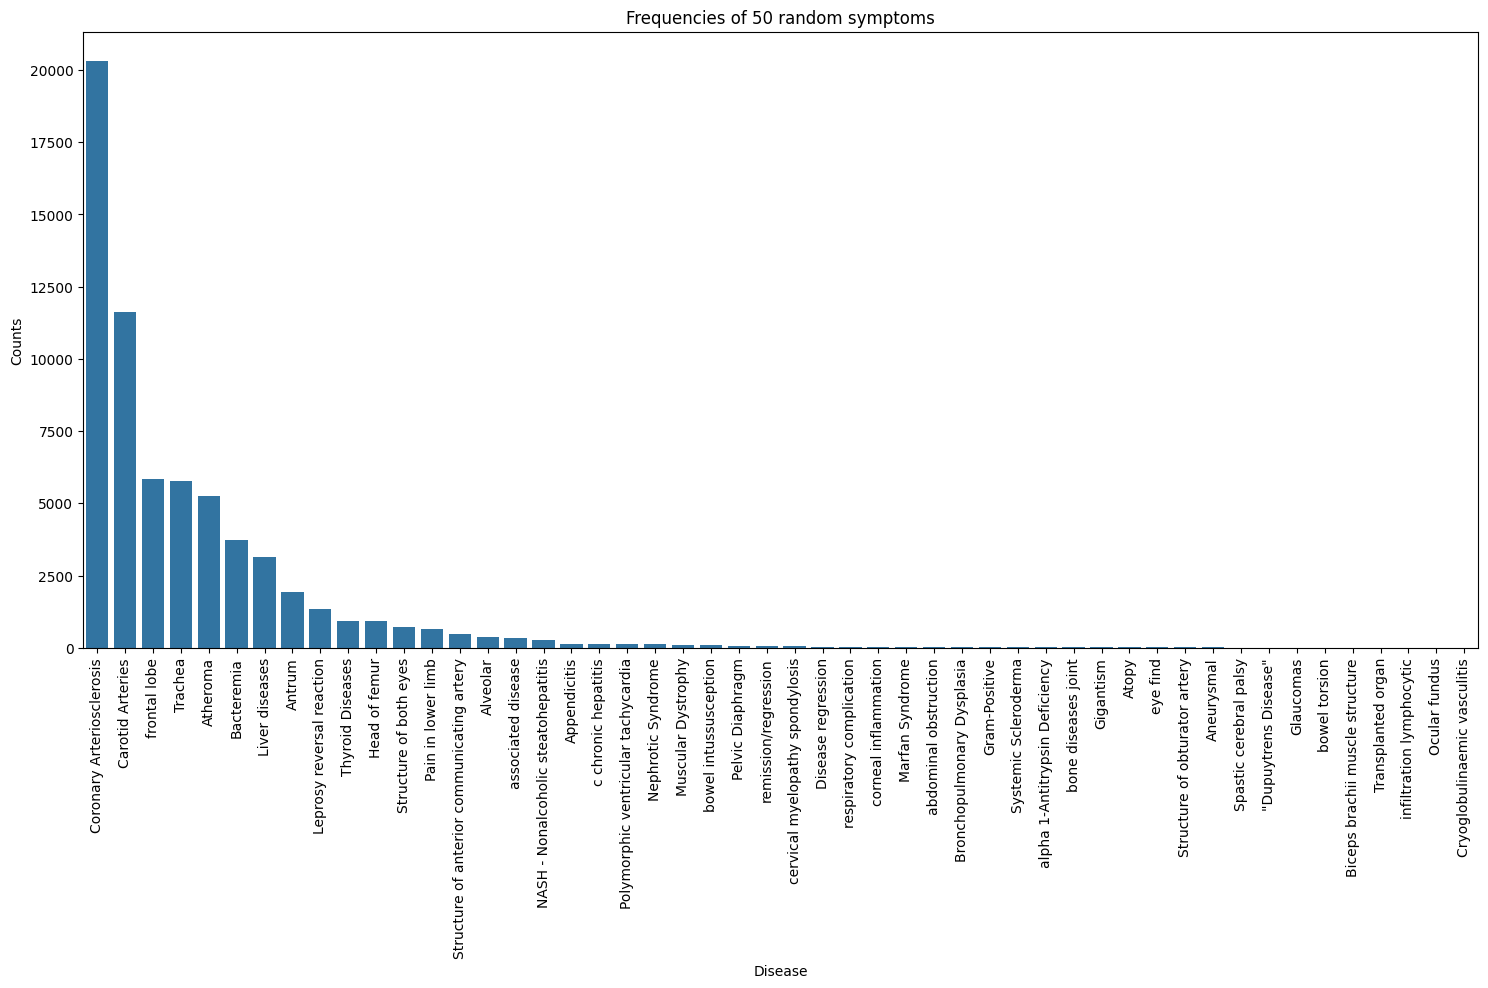

In [ ]:
temp_df = pd.DataFrame({"Disease": symptoms_counts.index,
                        "Counts":symptoms_counts.values})
temp_df = temp_df.sample(50).sort_values(by='Counts', ascending=False)

plt.figure(figsize=(18,8))
plt.title("Frequencies of 50 random symptoms")
sns.barplot(x='Disease', y='Counts', data=temp_df)
plt.xticks(rotation=90)
plt.show()

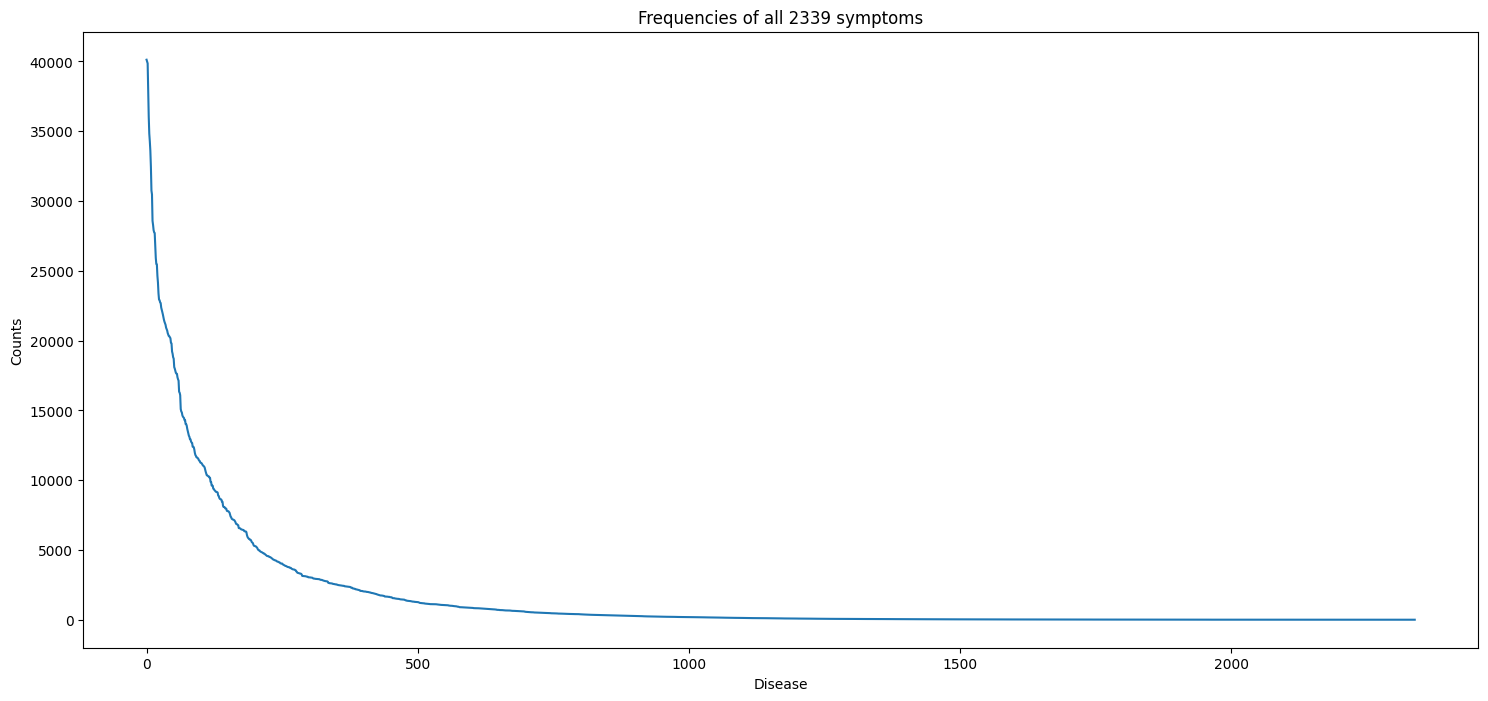

In [ ]:
temp_df = pd.DataFrame({"Disease": np.arange(len(symptoms_counts.index)),
                        "Counts":symptoms_counts.values})

plt.figure(figsize=(18,8))
plt.title("Frequencies of all 2339 symptoms")
sns.lineplot(x='Disease', y='Counts', data=temp_df)
plt.show()

## Utility

In [ ]:
def score_model(y_guess, y_true, name='Model'):
    print(classification_report(y_guess, y_true))
    rep = classification_report(y_guess, y_true, output_dict=True)
    rep['correct'] = (y_guess == y_true).mean()
    rep['name'] = name
    return rep

def string_time(elapsed):
    return "%im %is" %(int(elapsed / 60), int(elapsed % 60))

def build_analysis(log_data, feat):
    plt.figure(figsize=(24, 7))
    log_sorted = log_data.sort_values(by=[feat], ascending=False)
    splot = sns.barplot(x='Name', y=feat, data=log_sorted,
                        palette=log_sorted['Color'])

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.3f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

    plt.show()

In [ ]:
results = []

## ML Models

### Prepare Data for Training

In [ ]:
df = pd.read_csv('mimiciii-top10.csv')
df['MED_SYMPTOMS'] = df['MED_SYMPTOMS'].apply(literal_eval)
df['ICD9-CODE'] = df['ICD9-CODE'].apply(literal_eval)
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ICD9-CODE,MED_SYMPTOMS,NUM_NOTES
0,0,22532,167853.0,[42731],"[Cardiac chamber structure, Body of vertebra, ...",32
1,1,13702,107527.0,[51881],"[Cor pulmonale, Brain, Lung diseases, Angina P...",47
2,3,13702,196489.0,"[5849, 41401, 2724, 4019]","[Cardiac chamber structure, Anterior descendin...",26
3,4,26880,135453.0,"[4280, 42731]","[Benign Prostatic Hyperplasia, Sleep Apnea Syn...",39
4,5,53181,170490.0,[53081],"[Syndrome, capillaries lung, Symptoms, Left ve...",7


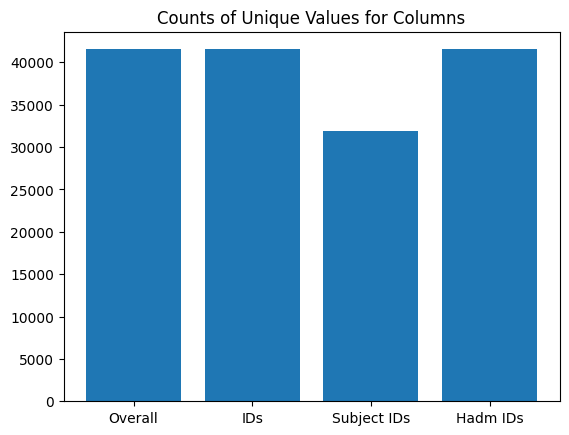

In [ ]:
names = ['Overall', 'IDs', 'Subject IDs', 'Hadm IDs']
heights = [len(df),
          len(np.unique(df['Unnamed: 0'])),
          len(np.unique(df['SUBJECT_ID'])),
          len(np.unique(df['HADM_ID']))]

plt.title("Counts of Unique Values for Columns")
plt.bar(names, heights)
plt.show()

We can see that for these colums all or almost all values are unique, so we should drop them for stability

In [ ]:
df = df.drop(columns=['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'])
df.head()

,ICD9-CODE,MED_SYMPTOMS,NUM_NOTES
0,[42731],"[Cardiac chamber structure, Body of vertebra, ...",32
1,[51881],"[Cor pulmonale, Brain, Lung diseases, Angina P...",47
2,"[5849, 41401, 2724, 4019]","[Cardiac chamber structure, Anterior descendin...",26
3,"[4280, 42731]","[Benign Prostatic Hyperplasia, Sleep Apnea Syn...",39
4,[53081],"[Syndrome, capillaries lung, Symptoms, Left ve...",7


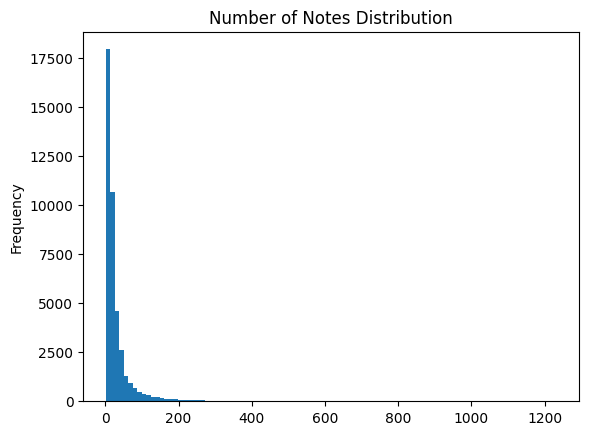

In [ ]:
df['NUM_NOTES'].plot(kind='hist', bins=100, title='Number of Notes Distribution')
plt.show()

In [ ]:
mlb = MultiLabelBinarizer(sparse_output=True)

dfonehot = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df['MED_SYMPTOMS']),
                index=df.index,
                columns=mlb.classes_)).drop(columns=['MED_SYMPTOMS'])

dfonehot.head()

,ICD9-CODE,NUM_NOTES,ABRASION DENT,ACD - Allergic contact dermatitis,ACS - Acute coronary syndrome,ACUTE DIS,ADPK,AG - Atrophic gastritis,AIDS HIV infection,AKU,...,strain symptom,sustained tachycardia ventricular,systolic dysfunction,tract,transient ischaemia,vagal nerve fibers,venous hypertension,ventricles wall,von Willebrand Disease,wing
0,[42731],32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[51881],47,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[5849, 41401, 2724, 4019]",26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[4280, 42731]",39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[53081],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = dfonehot.drop(columns=['ICD9-CODE'])
y = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(dfonehot['ICD9-CODE']),
                index=df.index,
                columns=mlb.classes_).to_numpy()

categorical = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_train.shape

(29075, 2279)

### Dummy Baseline

In [ ]:
clf = DummyClassifier(strategy='stratified')

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'Dummy'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.23      0.24      0.23      2639
           1       0.20      0.20      0.20      2625
           2       0.49      0.50      0.49      6106
           3       0.31      0.31      0.31      3746
           4       0.32      0.32      0.32      3844
           5       0.32      0.31      0.32      3998
           6       0.18      0.18      0.18      2239
           7       0.16      0.15      0.15      1912
           8       0.22      0.22      0.22      2758
           9       0.14      0.15      0.14      1919

   micro avg       0.30      0.30      0.30     31786
   macro avg       0.26      0.26      0.26     31786
weighted avg       0.29      0.30      0.29     31786
 samples avg       0.29      0.30      0.26     31786

Elapsed time: 0m 0s


### K Nearest Neighbors

In [ ]:
clf = KNeighborsClassifier()

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'KNN'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.36      0.10      0.16      2639
           1       0.52      0.21      0.30      2625
           2       0.55      0.69      0.61      6106
           3       0.72      0.60      0.65      3746
           4       0.56      0.38      0.46      3844
           5       0.62      0.29      0.40      3998
           6       0.52      0.31      0.39      2239
           7       0.42      0.09      0.14      1912
           8       0.47      0.10      0.17      2758
           9       0.39      0.05      0.09      1919

   micro avg       0.57      0.35      0.43     31786
   macro avg       0.51      0.28      0.34     31786
weighted avg       0.53      0.35      0.39     31786
 samples avg       0.49      0.36      0.39     31786

Elapsed time: 0m 46s


### Random Forest

In [ ]:
clf = RandomForestClassifier()

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'Random Forest'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.76      0.01      0.03      2639
           1       0.83      0.12      0.22      2625
           2       0.67      0.66      0.67      6106
           3       0.87      0.60      0.71      3746
           4       0.85      0.60      0.71      3844
           5       0.78      0.42      0.55      3998
           6       0.72      0.12      0.21      2239
           7       0.87      0.07      0.13      1912
           8       0.76      0.14      0.23      2758
           9       0.65      0.01      0.01      1919

   micro avg       0.77      0.36      0.49     31786
   macro avg       0.78      0.28      0.35     31786
weighted avg       0.77      0.36      0.43     31786
 samples avg       0.58      0.38      0.43     31786

Elapsed time: 0m 44s


### Catboost

In [ ]:
clf = CatBoostClassifier(random_state=179,
                         loss_function='MultiLogloss',
                         task_type="GPU",
                         verbose=False,)

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'Catboost'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      2639
           1       0.71      0.67      0.69      2625
           2       0.69      0.80      0.74      6106
           3       0.82      0.68      0.74      3746
           4       0.82      0.90      0.86      3844
           5       0.74      0.69      0.71      3998
           6       0.69      0.49      0.57      2239
           7       0.72      0.77      0.74      1912
           8       0.72      0.52      0.61      2758
           9       0.63      0.73      0.68      1919

   micro avg       0.73      0.70      0.71     31786
   macro avg       0.72      0.68      0.70     31786
weighted avg       0.73      0.70      0.71     31786
 samples avg       0.71      0.70      0.67     31786

Elapsed time: 0m 27s


### Catboost + Optuna

In [ ]:
def print_vals(d):
    ans = ''
    for key, val in d.items():
        ans += key + '=' + str(val) + ', '
    return ans[:-2]

def objective(trial: Trial, X_train, y_train, X_val, y_val) -> float:

    param = {
        'loss_function': 'MultiLogloss',
        'iterations' : trial.suggest_int('iterations', 100, 3000),
        'depth' : trial.suggest_int('depth', 4, 8),
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 5.00, log=True),
        'learning_rate' :trial.suggest_float('learning_rate', 1e-3, 0.05, log=True),
    }

    mod = CatBoostClassifier(**param, random_state=179, task_type="GPU")
    mod.fit(X_train, y_train,
            eval_set=((X_val, y_val)),
            early_stopping_rounds=100,
            logging_level='Silent',
        )

    y_guess = mod.predict(X_val)
    res = classification_report(y_guess, y_val, output_dict=True)['weighted avg']['f1-score']

    return res

In [ ]:
start = time.time()
study_catboost = optuna.create_study(direction='maximize', sampler=TPESampler())
study_catboost.optimize(lambda trial : objective(trial, X_train, y_train, X_val, y_val), n_trials=50)

print('Best trial: score {},\nparams {}'.format(study_catboost.best_trial.value, study_catboost.best_trial.params))

Best trial: score 0.7230617461722714,
params {'iterations': 2636, 'depth': 6, 'bagging_temperature': 0.5559828573579936, 'learning_rate': 0.021489279054925623}


In [ ]:
clf = CatBoostClassifier(**study_catboost.best_trial.params,
                         loss_function='MultiLogloss',
                         random_state=179,
                         logging_level='Silent',
                         task_type="GPU")

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'CatBoost+Optuna'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63      2639
           1       0.72      0.68      0.70      2625
           2       0.69      0.81      0.75      6106
           3       0.82      0.68      0.75      3746
           4       0.83      0.90      0.86      3844
           5       0.75      0.69      0.72      3998
           6       0.70      0.52      0.59      2239
           7       0.72      0.76      0.74      1912
           8       0.72      0.53      0.61      2758
           9       0.64      0.72      0.68      1919

   micro avg       0.73      0.71      0.72     31786
   macro avg       0.73      0.69      0.70     31786
weighted avg       0.73      0.71      0.72     31786
 samples avg       0.71      0.71      0.68     31786

Elapsed time: 1m 10s


### Text Catboost

In [ ]:
X = df.drop(columns=['ICD9-CODE'])
X['MED_SYMPTOMS'] = X['MED_SYMPTOMS'].apply(', '.join)
y = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(dfonehot['ICD9-CODE']),
                index=df.index,
                columns=mlb.classes_).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_train

,MED_SYMPTOMS,NUM_NOTES
19077,"Pneumothorax, Symptoms, Diabetes Mellitus, Ins...",9
10982,"Knee pain, Tricuspid Valve Insufficiency, Righ...",33
30893,"Sleep Apnea Syndromes, Symptoms, Hyperlipidemi...",10
4097,"Cardiac chamber structure, Anterior descending...",32
7708,"Pneumothorax, Disease Progression, Chest Pain,...",7
...,...,...
6265,"Cor pulmonale, Cardiac chamber structure, Tric...",14
11284,"Pneumothorax, Human Remains, Anterior descendi...",15
38158,"Pneumothorax, back discomfort, Chest Pain, Hyp...",18
860,"Cor pulmonale, Complication, infection, Cardia...",104


In [ ]:
clf = CatBoostClassifier(random_state=179,
                         text_features=['MED_SYMPTOMS'],
                         loss_function='MultiLogloss',
                         task_type="GPU",
                         verbose=False,)

start = time.time()
clf.fit(X_train, y_train)
y_guess = clf.predict(X_val)

results.append(score_model(y_val, y_guess, 'Catboost, Text Feats'))
print('Elapsed time: %s' %(string_time(time.time() - start)))

              precision    recall  f1-score   support

           0       0.68      0.45      0.54      2639
           1       0.71      0.67      0.69      2625
           2       0.70      0.78      0.74      6106
           3       0.82      0.67      0.74      3746
           4       0.83      0.90      0.86      3844
           5       0.75      0.69      0.72      3998
           6       0.67      0.51      0.58      2239
           7       0.72      0.77      0.74      1912
           8       0.72      0.53      0.61      2758
           9       0.64      0.74      0.69      1919

   micro avg       0.73      0.69      0.71     31786
   macro avg       0.72      0.67      0.69     31786
weighted avg       0.73      0.69      0.70     31786
 samples avg       0.71      0.70      0.67     31786

Elapsed time: 1m 54s


## DL Models

### Prepare Data for Training

In [ ]:
# one example for input features
mimic = pd.read_csv('mimiciii-top10.csv')
mimic['MED_SYMPTOMS'][0]

"['Cardiac chamber structure', 'Body of vertebra', 'Tricuspid Valve Insufficiency', 'Brain', 'Right ventricular segment', 'Cardiomyopathies', 'Myasthenia Gravis', 'frontal lobe', 'Uterus', 'Hip structure', 'Malnutrition', 'Chronic constipation', 'Heart', 'Aorta', 'Corpus striatum ventrale', 'Mitral Valve Insufficiency', 'Fever', 'Constipation', 'Atrial Fibrillation', 'Wheezing', 'Dehydration', 'Aortic Valve Insufficiency', 'Peripheral Arterial Diseases', 'anatomical layer', 'Pleural effusion disorder', 'Bone structure of sacrum', 'Aspiration Pneumonia', 'Pericardial sac structure', 'Signs and Symptoms', 'Dermatitis', 'Anemia', 'lymph nodes', 'Malaise', 'Pneumothorax', 'Heart failure', 'Endocarditis', 'Lymphadenopathy', 'Cellulitis', 'Pulmonary Embolism', 'Hemorrhage', 'Thoracic spine structure', 'Gallbladder', 'Pancreas', 'Urinary Bladder', 'Deep Vein Thrombosis', 'Left Ventricular Hypertrophy', 'diseases granulomatous', 'Hand', 'Atelectasis', 'Infectious disease of lung', 'Mitral Valv

In [ ]:
results[0].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'micro avg', 'macro avg', 'weighted avg', 'samples avg', 'correct', 'name'])

In [ ]:
MED_SYMPTOMS = string2list(mimic, 'MED_SYMPTOMS')
SYMPTOMS_unique = set([num for ppl in MED_SYMPTOMS for num in ppl])
icd9 = string2list(mimic, 'ICD9-CODE')
icd9_unique = set([num for ppl in icd9 for num in ppl])

In [ ]:
vocabulary = list(SYMPTOMS_unique)

In [ ]:
for i in tqdm(range(0, len(MED_SYMPTOMS))):
    for x in range(0, len(MED_SYMPTOMS[i])):
        index = vocabulary.index(MED_SYMPTOMS[i][x])
        MED_SYMPTOMS[i][x] = index

  0%|          | 0/41536 [00:00<?, ?it/s]

In [ ]:
terms = tf.ragged.constant(icd9)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

In [ ]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', '4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081']


In [ ]:
label_binarized = lookup(terms)[:, 1:]
print(f"Label-binarized representation: {label_binarized.shape}")

Label-binarized representation: (41536, 10)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    MED_SYMPTOMS, label_binarized.numpy(),
    test_size=0.3, random_state=42)

len(X_train),len(y_train),len(X_test),len(y_test)

(29075, 29075, 12461, 12461)

In [ ]:
length = [len(i) for i in X_train]
np.mean(length), np.max(length), np.median(length)

(94.22734307824591, 396, 87.0)

In [ ]:
X_train = tf.keras.utils.pad_sequences(
    X_train,
    maxlen=150,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)
X_test = tf.keras.utils.pad_sequences(
    X_test,
    maxlen=150,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0.0
)

### Attention-based Model

In [ ]:
def attention_m(query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

In [ ]:
def attention_model():

  int_sequences_input = tf.keras.Input(shape=(150,), dtype="int64")
  embedded_sequences = tf.keras.layers.Embedding(
                                                    20000,
                                                    128,
                                                    trainable=True,
                                                )(int_sequences_input)
  #flatten = tf.keras.layers.Flatten()(embedded_sequences)
  query = tf.keras.layers.Dense(128)(embedded_sequences)  # (batch_size, seq_len, embed_dim)
  key = tf.keras.layers.Dense(128)(embedded_sequences)  # (batch_size, seq_len, embed_dim)
  value = tf.keras.layers.Dense(128)(embedded_sequences)
  attention, weights = attention_m(query, key, value)
  pool = tf.keras.layers.GlobalMaxPooling1D()(attention)
  # dense = tf.keras.layers.Dense(386, activation="relu")(pool)
  # dense = tf.keras.layers.Dense(128, activation="relu")(pool)
  preds = tf.keras.layers.Dense(lookup.vocabulary_size()-1, activation="sigmoid")(pool)
  model = tf.keras.Model(int_sequences_input, preds)
  return model

In [ ]:
attention_model = attention_model()
attention_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)]
)

attention_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))
print()

Epoch 1/10
909/909 [==============================] - 25s 26ms/step - loss: 0.4200 - binary_accuracy: 0.8091 - val_loss: 0.3637 - val_binary_accuracy: 0.8373
Epoch 2/10
909/909 [==============================] - 9s 9ms/step - loss: 0.3490 - binary_accuracy: 0.8422 - val_loss: 0.3437 - val_binary_accuracy: 0.8459
Epoch 3/10
909/909 [==============================] - 9s 10ms/step - loss: 0.3332 - binary_accuracy: 0.8523 - val_loss: 0.3434 - val_binary_accuracy: 0.8501
Epoch 4/10
909/909 [==============================] - 7s 8ms/step - loss: 0.3225 - binary_accuracy: 0.8575 - val_loss: 0.3395 - val_binary_accuracy: 0.8464
Epoch 5/10
909/909 [==============================] - 8s 9ms/step - loss: 0.3151 - binary_accuracy: 0.8617 - val_loss: 0.3399 - val_binary_accuracy: 0.8504
Epoch 6/10
909/909 [==============================] - 7s 8ms/step - loss: 0.3098 - binary_accuracy: 0.8646 - val_loss: 0.3411 - val_binary_accuracy: 0.8472
Epoch 7/10
909/909 [==============================] - 8s 8ms/

In [ ]:
attention_model_y_scores = attention_model.predict(X_test)

390/390 [==============================] - 1s 3ms/step


In [ ]:
attention_model_y_pred=[]
threshold = 0.3
for sample in  attention_model_y_scores:
  attention_model_y_pred.append([1 if i>=threshold else 0 for i in sample ] )
attention_model_y_pred = np.array(attention_model_y_pred)
attention_model_y_pred

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
results.append(score_model(y_test[1::], attention_model_y_pred[1::], 'Attention NN'))

              precision    recall  f1-score   support

           0       0.63      0.90      0.74      6105
           1       0.67      0.78      0.72      3997
           2       0.82      0.90      0.86      3843
           3       0.69      0.82      0.75      3746
           4       0.57      0.72      0.63      2758
           5       0.62      0.62      0.62      2639
           6       0.62      0.76      0.68      2625
           7       0.54      0.72      0.62      2239
           8       0.62      0.70      0.65      1919
           9       0.70      0.74      0.72      1912

   micro avg       0.65      0.79      0.71     31783
   macro avg       0.65      0.76      0.70     31783
weighted avg       0.65      0.79      0.71     31783
 samples avg       0.65      0.79      0.68     31783



### Attention + CNN

In [ ]:
def attention_CNN_model():
    int_sequences_input = tf.keras.Input(shape=(150,), dtype="int64")
    embedded_sequences = tf.keras.layers.Embedding(
        input_dim=20000,
        output_dim=128,
        trainable=True,
    )(int_sequences_input)

    # Dense layers for attention mechanism
    query = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)
    key = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)
    value = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)

    # Using built-in Attention layer
    attention, weights = attention_m(query, key, value)
    # Convolutional layers after attention
    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(attention)
    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(conv1)
    pool = tf.keras.layers.GlobalMaxPooling1D()(conv2)

    preds = tf.keras.layers.Dense(lookup.vocabulary_size()-1, activation="sigmoid")(pool)
    model = tf.keras.Model(inputs=int_sequences_input, outputs=preds)
    return model

In [ ]:
attention_CNN_model = attention_CNN_model()
attention_CNN_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)]
)

attention_CNN_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
909/909 [==============================] - 36s 33ms/step - loss: 0.4563 - binary_accuracy: 0.7917 - val_loss: 0.4003 - val_binary_accuracy: 0.8188
Epoch 2/10
909/909 [==============================] - 9s 10ms/step - loss: 0.3795 - binary_accuracy: 0.8279 - val_loss: 0.3687 - val_binary_accuracy: 0.8329
Epoch 3/10
909/909 [==============================] - 9s 10ms/step - loss: 0.3581 - binary_accuracy: 0.8383 - val_loss: 0.3589 - val_binary_accuracy: 0.8378
Epoch 4/10
909/909 [==============================] - 9s 10ms/step - loss: 0.3451 - binary_accuracy: 0.8446 - val_loss: 0.3493 - val_binary_accuracy: 0.8439
Epoch 5/10
909/909 [==============================] - 8s 9ms/step - loss: 0.3351 - binary_accuracy: 0.8501 - val_loss: 0.3467 - val_binary_accuracy: 0.8434
Epoch 6/10
909/909 [==============================] - 13s 15ms/step - loss: 0.3283 - binary_accuracy: 0.8541 - val_loss: 0.3462 - val_binary_accuracy: 0.8466
Epoch 7/10
909/909 [==============================] - 18s

In [ ]:
attention_CNN_y_scores = attention_CNN_model.predict(X_test)
attention_CNN_y_pred=[]
threshold = 0.3
for sample in  attention_CNN_y_scores:
  attention_CNN_y_pred.append([1 if i>=threshold else 0 for i in sample ] )
attention_CNN_y_pred = np.array(attention_CNN_y_pred)


390/390 [==============================] - 2s 4ms/step


In [ ]:
results.append(score_model(y_test[1::], attention_CNN_y_pred[1::], 'Attention+CNN'))

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      6105
           1       0.60      0.87      0.71      3997
           2       0.82      0.90      0.86      3843
           3       0.73      0.77      0.75      3746
           4       0.52      0.76      0.62      2758
           5       0.66      0.55      0.60      2639
           6       0.66      0.70      0.68      2625
           7       0.55      0.70      0.62      2239
           8       0.63      0.79      0.70      1919
           9       0.68      0.84      0.75      1912

   micro avg       0.65      0.79      0.71     31783
   macro avg       0.65      0.78      0.70     31783
weighted avg       0.65      0.79      0.71     31783
 samples avg       0.66      0.80      0.69     31783



### Attention + BiLSTM

In [ ]:
def attention_BiLSTM_create_model():
    int_sequences_input = tf.keras.Input(shape=(150,), dtype="int64")
    embedded_sequences = tf.keras.layers.Embedding(
        input_dim=20000,
        output_dim=128,
        trainable=True,
    )(int_sequences_input)

    # Dense layers for attention mechanism preparation
    query = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)
    key = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)
    value = tf.keras.layers.Dense(128, activation='relu')(embedded_sequences)

    # Using built-in Attention layer
    attention, weights = attention_m(query, key, value)
    # BiLSTM layer after attention mechanism
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(attention)
    # You could add more BiLSTM layers or adjust the LSTM units based on your needs

    # A pooling layer or you could use tf.keras.layers.GlobalAveragePooling1D() as well
    pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)

    # Prediction layer
    preds = tf.keras.layers.Dense(lookup.vocabulary_size()-1, activation="sigmoid")(pool)
    model = tf.keras.Model(inputs=int_sequences_input, outputs=preds)
    return model

In [ ]:
attention_BiLSTM_model = attention_BiLSTM_create_model()
attention_BiLSTM_model .compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)]
)

attention_BiLSTM_model .fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
909/909 [==============================] - 41s 40ms/step - loss: 0.4451 - binary_accuracy: 0.7995 - val_loss: 0.3878 - val_binary_accuracy: 0.8239
Epoch 2/10
909/909 [==============================] - 20s 22ms/step - loss: 0.3639 - binary_accuracy: 0.8369 - val_loss: 0.3633 - val_binary_accuracy: 0.8348
Epoch 3/10
909/909 [==============================] - 20s 22ms/step - loss: 0.3491 - binary_accuracy: 0.8435 - val_loss: 0.3495 - val_binary_accuracy: 0.8413
Epoch 4/10
909/909 [==============================] - 23s 25ms/step - loss: 0.3365 - binary_accuracy: 0.8489 - val_loss: 0.3399 - val_binary_accuracy: 0.8473
Epoch 5/10
909/909 [==============================] - 21s 23ms/step - loss: 0.3274 - binary_accuracy: 0.8541 - val_loss: 0.3358 - val_binary_accuracy: 0.8475
Epoch 6/10
909/909 [==============================] - 31s 34ms/step - loss: 0.3221 - binary_accuracy: 0.8574 - val_loss: 0.3362 - val_binary_accuracy: 0.8502
Epoch 7/10
909/909 [==============================] 

In [ ]:
attention_BiLSTM_y_scores = attention_BiLSTM_model.predict(X_test)
attention_BiLSTM_y_pred=[]
threshold = 0.3
for sample in  attention_BiLSTM_y_scores:
  attention_BiLSTM_y_pred.append([1 if i>=threshold else 0 for i in sample ] )
attention_BiLSTM_y_pred = np.array(attention_BiLSTM_y_pred)

390/390 [==============================] - 6s 10ms/step


In [ ]:
results.append(score_model(y_test[1::], attention_BiLSTM_y_pred[1::], 'Attention+BiLSTM'))

              precision    recall  f1-score   support

           0       0.62      0.93      0.74      6105
           1       0.63      0.84      0.72      3997
           2       0.82      0.90      0.86      3843
           3       0.63      0.90      0.74      3746
           4       0.59      0.70      0.64      2758
           5       0.54      0.84      0.66      2639
           6       0.59      0.82      0.69      2625
           7       0.54      0.73      0.62      2239
           8       0.62      0.81      0.71      1919
           9       0.67      0.86      0.75      1912

   micro avg       0.63      0.85      0.72     31783
   macro avg       0.63      0.83      0.71     31783
weighted avg       0.63      0.85      0.72     31783
 samples avg       0.64      0.85      0.70     31783



## Result Analysis

In [ ]:
logdata = pd.DataFrame()
logdata['Name'] = [x['name'] for x in results]
logdata['Weighted Avg F1'] = [x['weighted avg']['f1-score'] for x in results]
logdata['Weighted Avg Precision'] = [x['weighted avg']['precision'] for x in results]
logdata['Weighted Avg Recall'] = [x['weighted avg']['recall'] for x in results]
logdata['Correct Fraction'] = [x['correct'] for x in results]
logdata['Macro Avg F1'] = [x['macro avg']['f1-score'] for x in results]
logdata['Micro Avg F1'] = [x['micro avg']['f1-score'] for x in results]
logdata['Color'] = np.array(sns.color_palette("hls", len(results)).as_hex())

In [ ]:
logdata

,Name,Weighted Avg F1,Weighted Avg Precision,Weighted Avg Recall,Correct Fraction,Macro Avg F1,Micro Avg F1,Color
0,KNN,0.393512,0.534637,0.351538,0.765886,0.336710,0.433765,#db5f57
1,Random Forest,0.430012,0.773810,0.360379,0.808860,0.346127,0.490284,#dbae57
2,Catboost,0.709143,0.728365,0.700277,0.856448,0.695347,0.713361,#b9db57
3,Attention,0.712990,0.653874,0.789007,0.837825,0.698703,0.712810,#69db57
4,Attention+CNN,0.713660,0.654709,0.794827,0.837103,0.702669,0.713404,#57db94
5,Attention+BiLSTM,0.722770,0.632273,0.849542,0.832512,0.712637,0.721267,#57d3db
6,"Catboost, as Text",0.704471,0.730937,0.689989,0.856095,0.690137,0.709819,#5784db
7,Dummy,0.294930,0.294926,0.295036,0.641201,0.256733,0.295528,#7957db
8,CatBoost+Optuna,0.715914,0.732517,0.708079,0.859128,0.702228,0.719441,#c957db
9,CatBoost+Optuna,0.715914,0.732517,0.708079,0.859128,0.702228,0.719441,#db579e


In [ ]:
def build_analysis(log_data, feat):
    plt.figure(figsize=(24, 7))
    log_sorted = log_data.sort_values(by=[feat], ascending=False)
    splot = sns.barplot(x='Name', y=feat, data=log_sorted,
                        palette=list(log_sorted['Color']))

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.3f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

    plt.show()

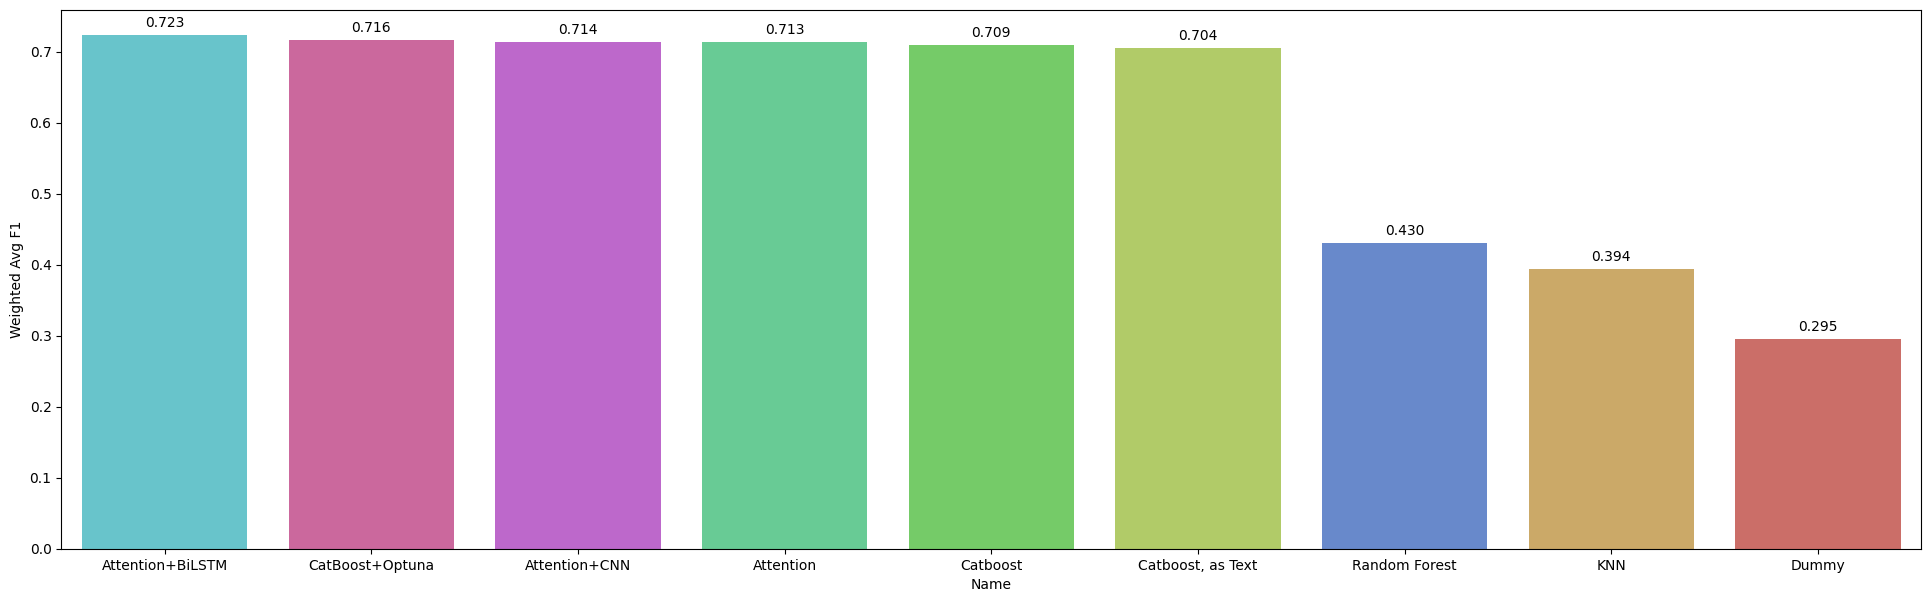

In [ ]:
build_analysis(logdata, 'Weighted Avg F1')

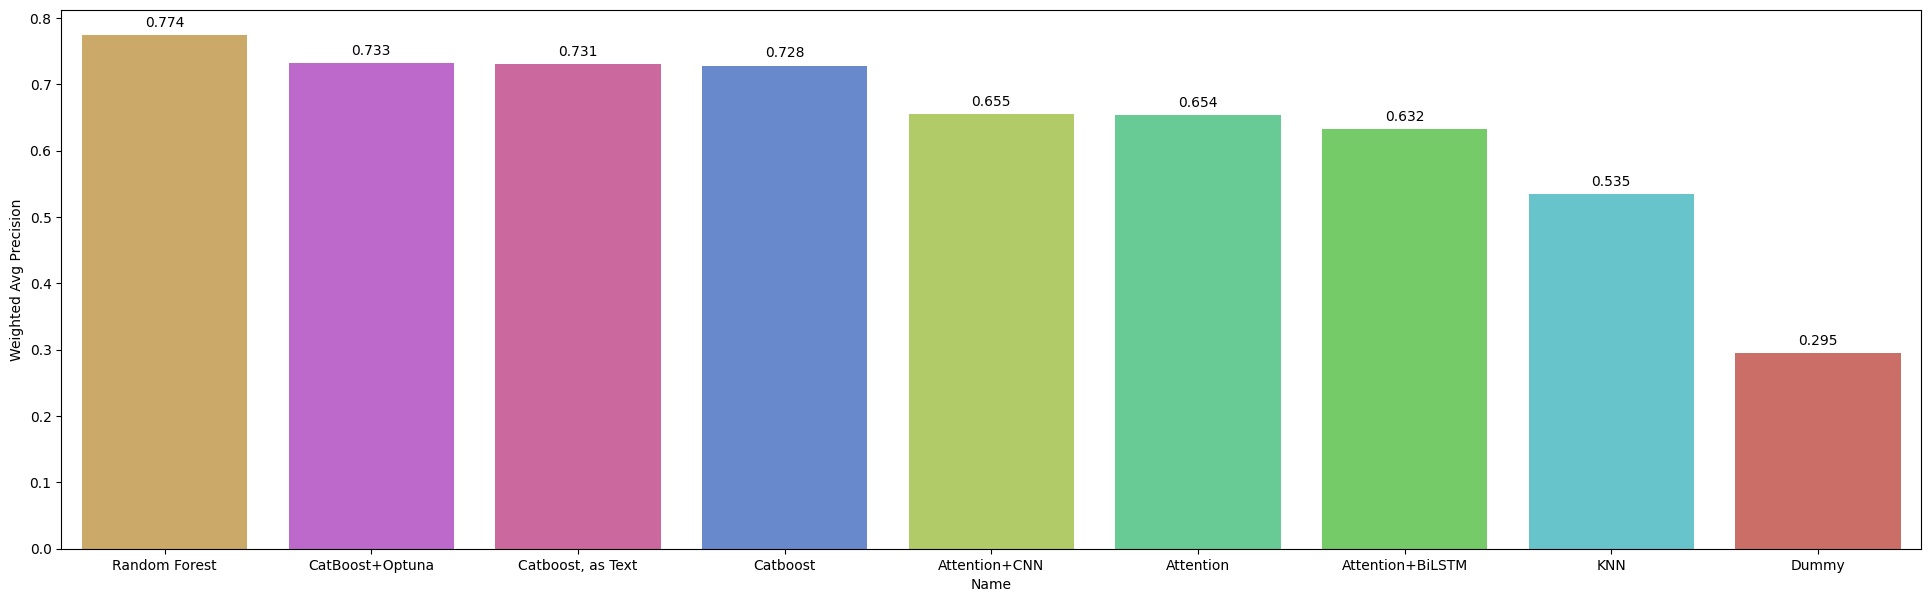

In [ ]:
build_analysis(logdata, 'Weighted Avg Precision')

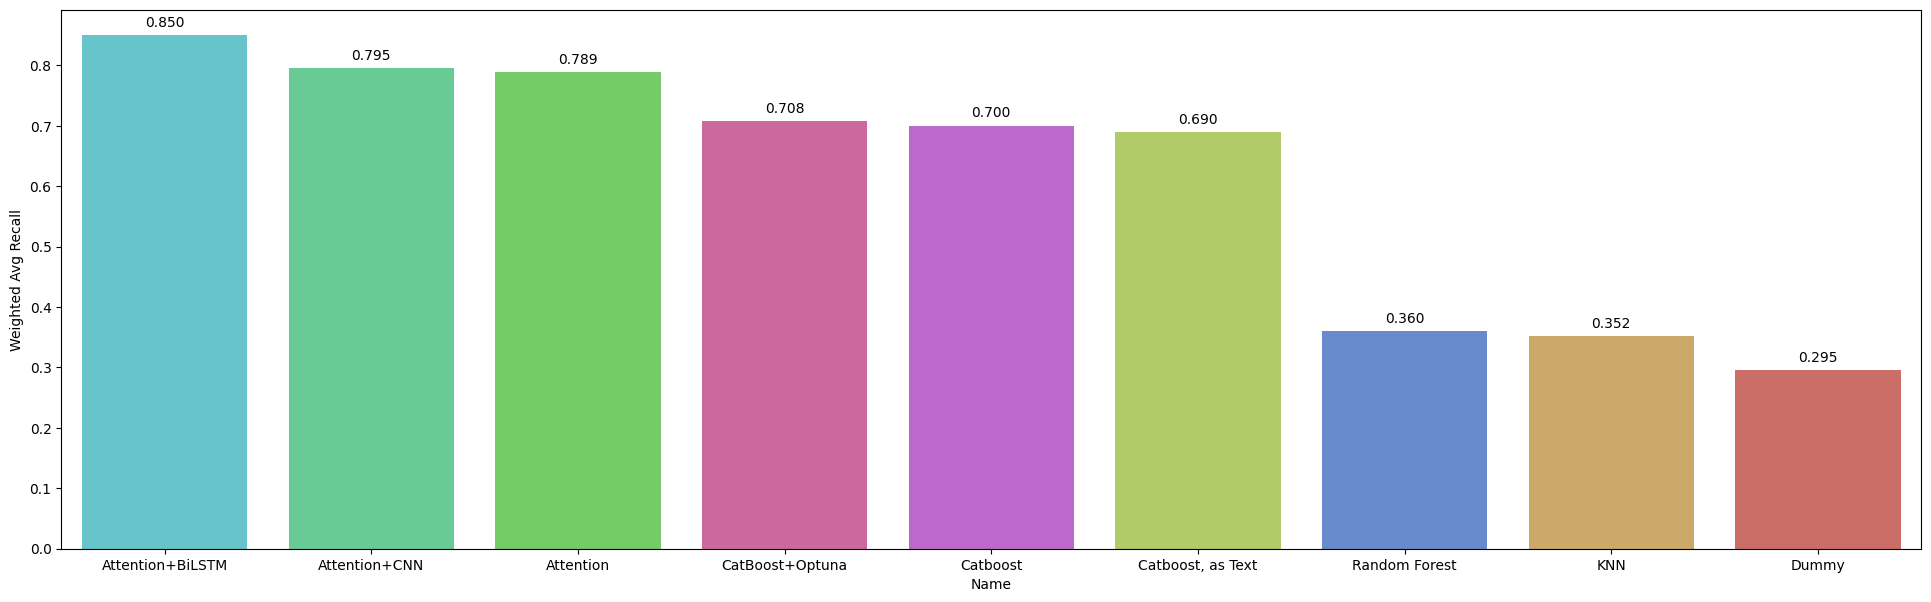

In [ ]:
build_analysis(logdata, 'Weighted Avg Recall')

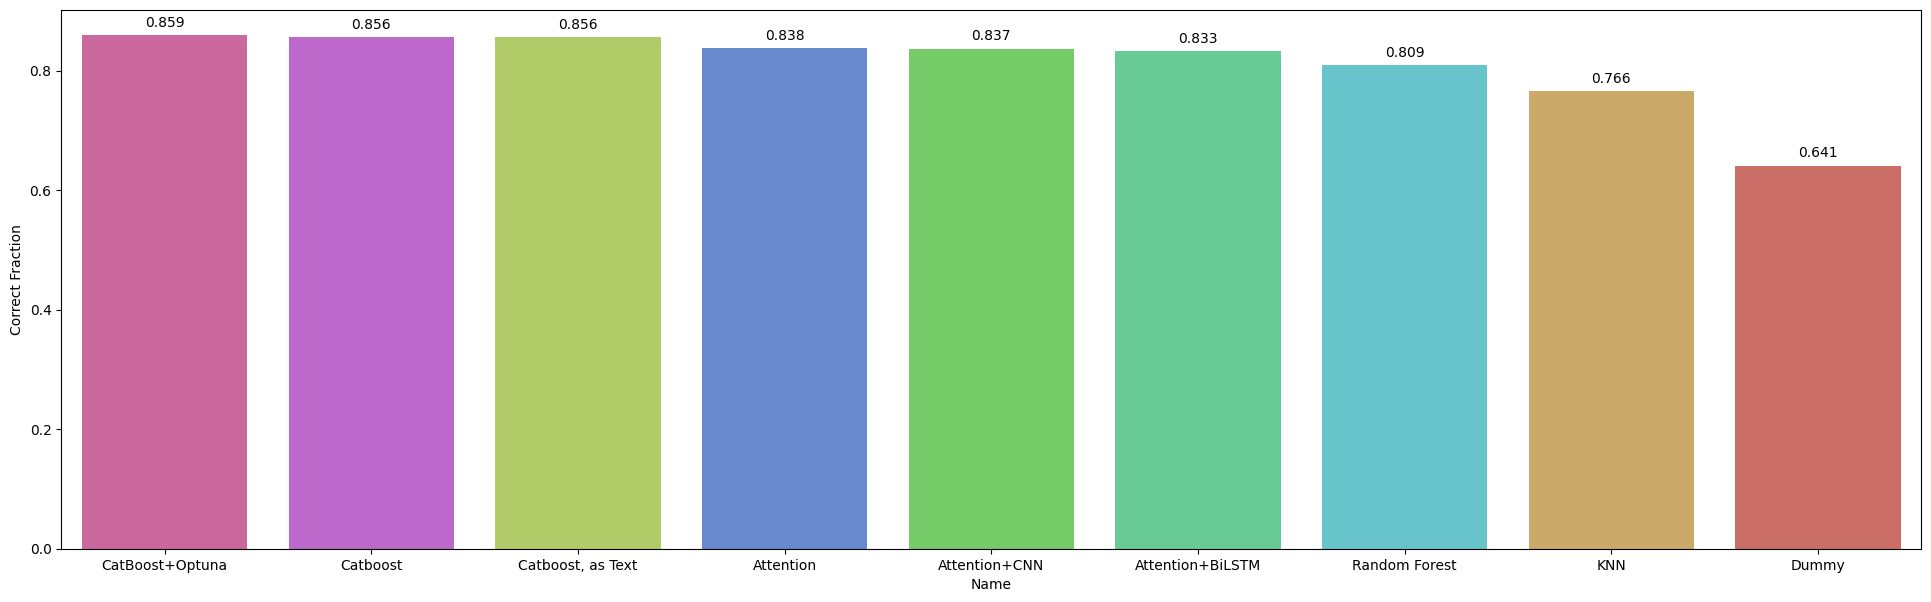

In [ ]:
build_analysis(logdata, 'Correct Fraction')